<a href="https://colab.research.google.com/github/simrathanspal/deep_models_from_scratch/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
corpus = [
    "The king is a strong and wise ruler.",
    "The queen is a wise and powerful monarch.",
    "A man must be strong to be a king.",
    "A woman can be a powerful monarch.",
    "The ruler of the kingdom is either a king or a queen.",
    "He is the king and she is the queen.",
]

# Two word2vec architectures

Shallow 2 layer network
2 layers because two sets of learnable parameters

1.   input -> hidden
2.   hidden -> output



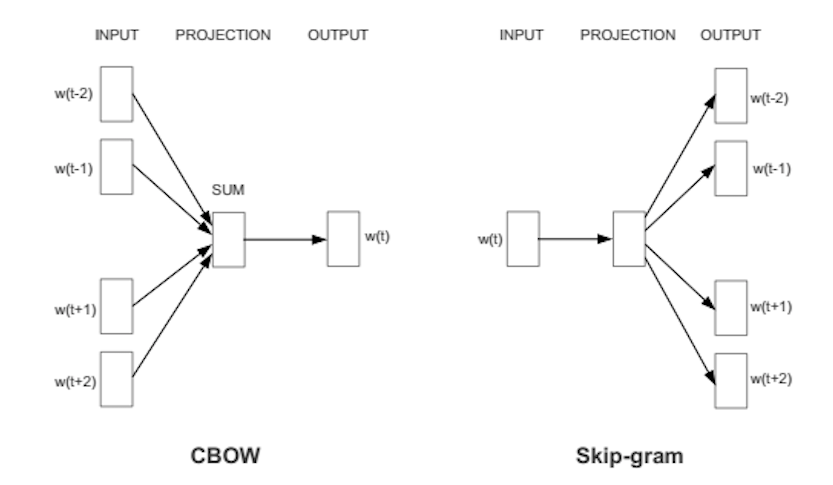

## Skip Gram - predict the surrounding context

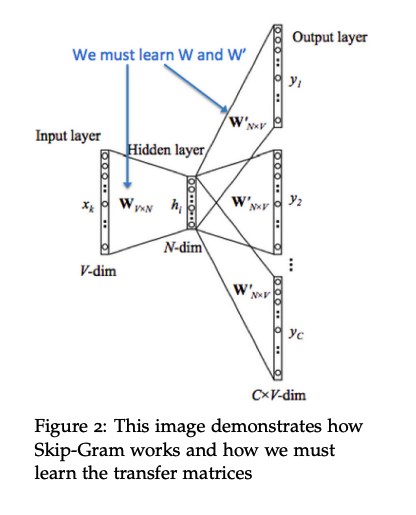

In the skip gram model we are training bunch of target and context token pairs

Consider the sentence `"The quick brown fox jumped over the dog"`

If target word is `jumped` then we create pairs like

`(jumped, brown), (jumped, fox), (jumped, over), (jumped, the)`

We dont care about the position here, all we care about is teaching the model the associations and updating the target embedding.

In my view this is a confusing training setup as one word has to predict always different words. But as a training task I think it is a good setup because it avoids overfitting and forces the model to generalise well.

Especially important as the complexity of the task is not much - just predicting the next word.

In [15]:
import numpy as np

vocab = sorted(np.unique(np.concatenate([c.split() for c in corpus])))
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}


def one_hot_vec(index, size):
  vec = np.zeros(size)
  vec[index] = 1
  return vec

In [16]:
def generate_skip_gram_data(window_size=1):
  training_data = []
  for index, word in enumerate(vocab):
    target_word = word
    target_index = index
    context = []
    for j in range(max(0,index-window_size) , min(len(vocab), index+window_size+1)):
      if index == j:
        continue
      context.append(j)
      training_data.append([target_index, context])
    return training_data



In [17]:
# Model parameters
hidden_dim = 5
learning_rate = 0.01
epochs = 25 # Number of times the model sees whole data

# Weight initialisation
# Random value from -1 (inclusive) to 1 (exclusive)
W1 = np.random.uniform(-1, 1, (len(vocab), hidden_dim))
W2 = np.random.uniform(-1, 1, (hidden_dim, len(vocab)))

In [18]:
training_data_skip = generate_skip_gram_data()
print(training_data_skip[0])


# ---- Training loop ----
for epoch in range(epochs):
  total_loss = 0
  for target_idx, context in training_data_skip:
    # 1. Get one hot vector for target word
    x = one_hot_vec(target_idx, len(vocab))

    # 2. Get the embedding
    h = W1.T@x

    # 3. Score for all context words
    u = W2.T@h

    # 4. Calculate probabilities
    y_pred = np.exp(u)/np.sum(np.exp(u))


    # --- Calculate loss --- #
    loss = -np.log(y_pred[context])
    total_loss += loss

    # ---- Backward pass ---- #

    # Explanation
    #
    # Consider we have bunch of neuron weight going to output neuron.
    # We want to now distribute the Loss at output neuron to all the previous neurons.
    # For this we need to understand what is the contribution of every previous neuron to the loss.
    #
    # dLoss/dW = (dLoss/dOutput).(dOutput/dW)
    # Change in Loss for a small change in weights =
    # (Change in Loss for a small change in Output) x (Change in Output for a small change in weights)
    # dOutput/dwi = d(w0X0 + w1x1 + ...wiXi+... )/dwi
    # When taking a derivative for wi, all the other weights are treated as constant and derivative will be 0
    # Hence dOutput/dwi = Xi (same as activation at last layer and input at the first layer) or h in our case
    #
    # Now we need to compute (dL/dOutput)
    # Loss = cross entropy of softmax
    # Output = softmax of logits
    # First we take softmax (y_pred) = e^(logit_i)/ sum of all logit exponentials
    # Next we take cross entropy = - Sum of all classes [ y_true.log(y_pred) ]
    # derivative of cross entropy = y_pred - y_actual
    # Note the derivative of other loss function need not be y_pred - y_loss hence we can't simiplify like this

    # 1. calculate error
    # error is difference between predicted and expected probabilities
    e = y_pred.copy()
    # y_pred - y_act
    # 0.85 - 1 => -0.15 => Gives the direction that prob is low
    # 0.85 - 0 => 0.85 => Gives the direction that prob is high
    # Hence we need to subtract -1 only for target class
    e[context] -= 1

    # 2. Calculate the gradient for W2
    grad_W2 = np.outer(h, e)

    # 3. Calculate the gradient for W1
    # Distributing the error back is slightly unintuitive but we can understand this with an analogy
    # Imagine that hidden layer is a water source and from this water source the water is flowing to
    # final destination. Every neuron connection can be thought of as a channel.
    # The width of the channel defines how much water flows through it and this is what our weights are
    # controlling - how much information flows.
    # Now when we want to back propogate the error we need to send it through the same channel
    # Hence the error reaching the previous layer is distributed by the weight
    grad_W1 = np.outer(x, W2@e)

    # --- Update weights --- #
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2

  print(f"Epoch: {epoch+1}, Loss: {total_loss}")
print("\n--- Skip-gram Final Embeddings (W1) ---")
print(W1)


[0, [1]]
Epoch: 1, Loss: [3.25288028]
Epoch: 2, Loss: [3.21570907]
Epoch: 3, Loss: [3.17883444]
Epoch: 4, Loss: [3.14224227]
Epoch: 5, Loss: [3.10591887]
Epoch: 6, Loss: [3.06985098]
Epoch: 7, Loss: [3.03402575]
Epoch: 8, Loss: [2.99843077]
Epoch: 9, Loss: [2.96305404]
Epoch: 10, Loss: [2.92788401]
Epoch: 11, Loss: [2.89290953]
Epoch: 12, Loss: [2.8581199]
Epoch: 13, Loss: [2.82350487]
Epoch: 14, Loss: [2.78905462]
Epoch: 15, Loss: [2.75475976]
Epoch: 16, Loss: [2.72061139]
Epoch: 17, Loss: [2.68660104]
Epoch: 18, Loss: [2.65272072]
Epoch: 19, Loss: [2.6189629]
Epoch: 20, Loss: [2.58532055]
Epoch: 21, Loss: [2.5517871]
Epoch: 22, Loss: [2.51835651]
Epoch: 23, Loss: [2.48502323]
Epoch: 24, Loss: [2.45178221]
Epoch: 25, Loss: [2.41862895]

--- Skip-gram Final Embeddings (W1) ---
[[ 0.2657294  -0.16155483  0.75810257 -0.89256274  0.55259679]
 [-0.94387175  0.97070934  0.54636745 -0.76811804  0.95734114]
 [-0.3003033  -0.04123125 -0.689673   -0.43038297 -0.31817699]
 [ 0.71633476  0.622865

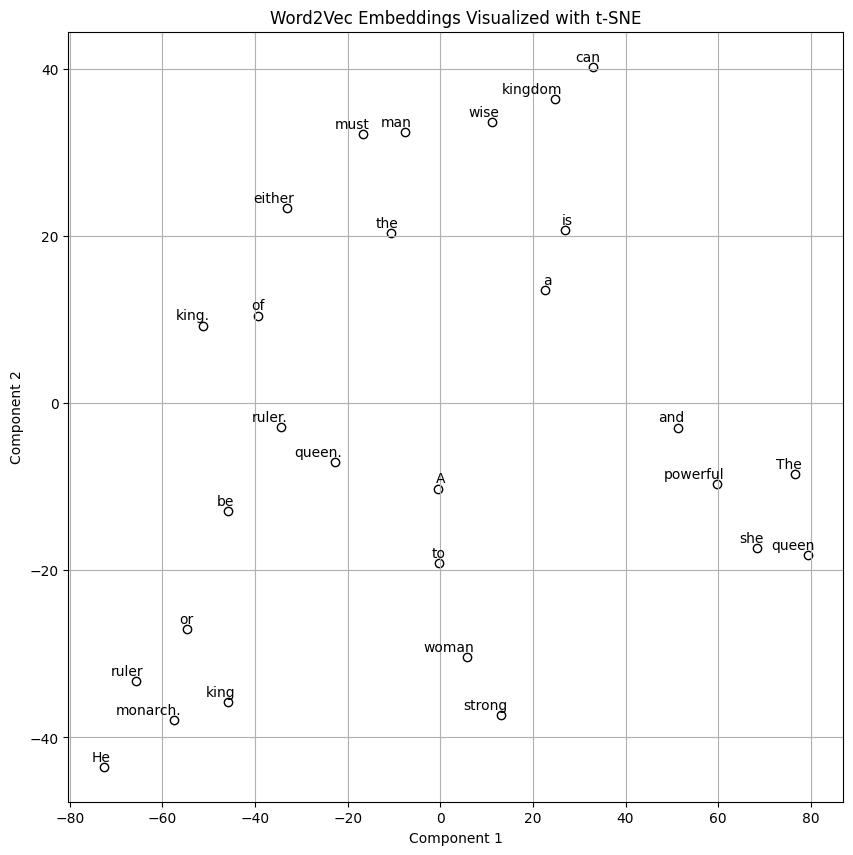

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(W1)
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='w')

for i, word in enumerate(vocab):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2), # Small offset
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.title('Word2Vec Embeddings Visualized with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# CBOW - Given the surrounding context predict the target

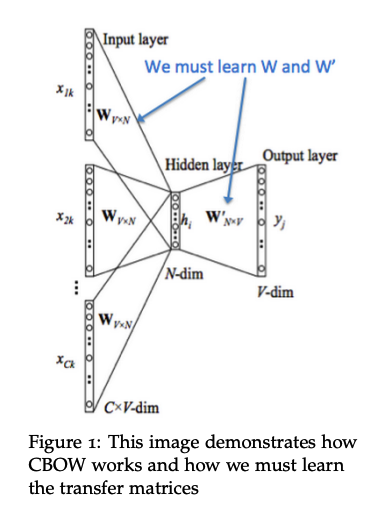

In CBOW we do the opposite of skip gram - here we predict the target

To predict the target we take the context window - `(brown, fox, over, the)`

We take the embeddings of these tokens - average it and then predict `jumped`




In [23]:
def generate_training_cbow(window_size=1):
  training_data = []
  for index, target in enumerate(vocab):
    context = []
    for j in range(max(i-window_size, 0), min(i+window_size+1, len(vocab))):
      if i == j :
        continue
      context.append(j)

    training_data.append((context, index ))
  return training_data

In [27]:
training_data_cbow = generate_training_cbow()

# --- Model training --- #

embedding_dim = 5
learning_rate = 0.01
epochs = 25

W1 = np.random.uniform(-1, 1, (len(vocab), embedding_dim))
W2 = np.random.uniform(-1, 1, (embedding_dim, len(vocab)))

# --- Training loop --- #
for epoch in range(epochs):
  total_loss = 0
  for context, target in training_data_cbow:

    # --- Forward pass --- #

    # Training data generation
    # W1 (vocab, hidden)
    # X is one hot encoded hence dimension is len(vocab)
    # It can be treated as row vector or column vector. Numpy handles that internally for us

    # W1.T@X
    # (hidden, vocab)@(vocab, 1)
    context_vectors = W1[context]
    h = np.mean(context_vectors, axis=0)

    # Here if we want to use previous pattern of W1.T@X, we will need to carefully
    # work with the dimensions as we are using multiple words in CBOW
    # W1 = (vocab, hidden)
    # X = (window, vocab)
    # Note both need to be transposed if we want dot product to be possible
    # W1.T@X.T
    # Filtering is easier code in this example as we need to form X and then compute

    u = W2.T @ h

    # Calculate y_pred
    y_pred = np.exp(u)/np.sum(np.exp(u))

    # --- Calculate loss --- #

    loss = -np.log(y_pred[target])
    total_loss += loss

    # --- Backward pass --- #
    # Imagine the network looks like
    # Input -> W1 ->Hidden -> W2 -> Vocab output
    # Hence we have e (error vector of size vocab)
    e = y_pred.copy()
    e[target] -= 1

    # grad_W2 ie how much does error changes wrt W2
    # dL/dW2 = dL/du . du/dW2
    # dL/dW2 = e . h
    grad_W2 = np.outer(h, e)


    # Now we need to compute grad_W1
    # For that we need to know what is the error that propogated to hidden layer
    # The propogation of the error is limited by the W2
    # Hence error_at_hidden = W2 @ e
    error_at_hidden = W2 @ e

    # Since the input in CBOW is not created by single input
    # We can't write np.outer(x, W2@e) like Skip gram
    # error_at_hidden gives us total error for the averaged hidden layer
    # We need to now loop through each word that was averaged and
    # give it averaged error
    grad_W1 = np.zeros_like(W1)
    for id in context:
      grad_W1[id] += error_at_hidden / len(context)

    # --- Update the weights --- #
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2

  print(f"Epoch: {epoch+1}, Loss: {total_loss}")
print("\n--- CBOW Final Embeddings (W1) ---")
print(W1)


Epoch: 1, Loss: 96.11087615397207
Epoch: 2, Loss: 95.75517446445802
Epoch: 3, Loss: 95.47076852291876
Epoch: 4, Loss: 95.23950642522101
Epoch: 5, Loss: 95.04856783913033
Epoch: 6, Loss: 94.88873304559947
Epoch: 7, Loss: 94.75326147701774
Epoch: 8, Loss: 94.63714943212713
Epoch: 9, Loss: 94.53662933684211
Epoch: 10, Loss: 94.44882614183058
Epoch: 11, Loss: 94.37151788260236
Epoch: 12, Loss: 94.30296646426483
Epoch: 13, Loss: 94.24179652158482
Epoch: 14, Loss: 94.18690765364046
Epoch: 15, Loss: 94.13741012565475
Epoch: 16, Loss: 94.09257726702575
Epoch: 17, Loss: 94.05180987840774
Epoch: 18, Loss: 94.01460936473687
Epoch: 19, Loss: 93.98055726938338
Epoch: 20, Loss: 93.94929954649005
Epoch: 21, Loss: 93.92053437075351
Epoch: 22, Loss: 93.89400260997026
Epoch: 23, Loss: 93.86948031787625
Epoch: 24, Loss: 93.84677277164256
Epoch: 25, Loss: 93.82570969924622

--- CBOW Final Embeddings (W1) ---
[[ 0.49047663  0.55567241  0.68968814  0.29821775  0.86579826]
 [-0.69904543  0.0299256  -0.107933

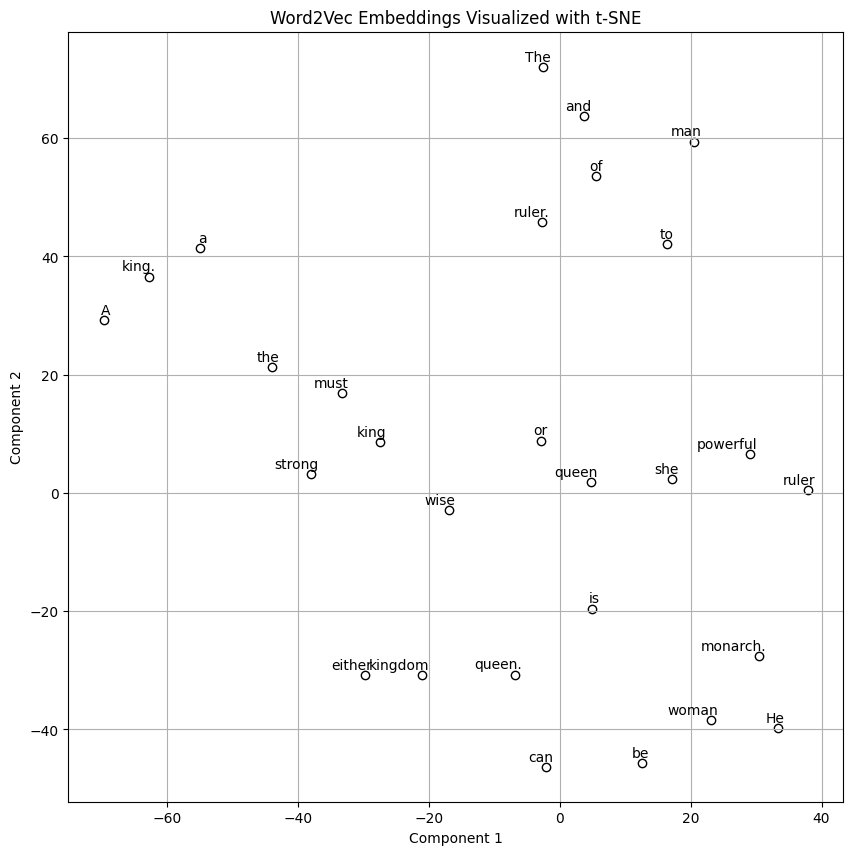

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(W1)
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='w')

for i, word in enumerate(vocab):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2), # Small offset
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.title('Word2Vec Embeddings Visualized with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()